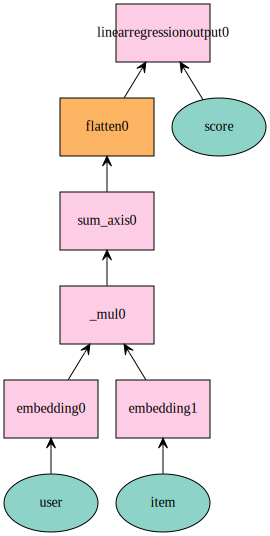

In [4]:
from mxnet import nd
from mxnet.gluon import nn

def conv_block(channels):
    out = nn.Sequential()
    out.add(
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Conv2D(channels, kernel_size=3, padding=1)
    )
    return out

class DenseBlock(nn.Block):
    def __init__(self, layers, growth_rate, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.net = nn.Sequential()
        for i in range(layers):
            self.net.add(conv_block(growth_rate))

    def forward(self, x):
        for layer in self.net:
            out = layer(x)
            x = nd.concat(x, out, dim=1)
        return x
    
dblk = DenseBlock(2, 10)
dblk.initialize()

x = nd.random.uniform(shape=(4,3,8,8))
dblk(x).shape

def transition_block(channels):
    out = nn.Sequential()
    out.add(
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Conv2D(channels, kernel_size=1),
        nn.AvgPool2D(pool_size=2, strides=2)
    )
    return out

tblk = transition_block(10)
tblk.initialize()

tblk(x).shape

init_channels = 64
growth_rate = 32
block_layers = [6, 12, 24, 16]
num_classes = 10

def dense_net():
    net = nn.Sequential()
    # add name_scope on the outermost Sequential
    with net.name_scope():
        # first block
        net.add(
            nn.Conv2D(init_channels, kernel_size=7,
                      strides=2, padding=3),
            nn.BatchNorm(),
            nn.Activation('relu'),
            nn.MaxPool2D(pool_size=3, strides=2, padding=1)
        )
        # dense blocks
        channels = init_channels
        for i, layers in enumerate(block_layers):
            net.add(DenseBlock(layers, growth_rate))
            channels += layers * growth_rate
            if i != len(block_layers)-1:
                net.add(transition_block(channels//2))
        # last block
        net.add(
            nn.BatchNorm(),
            nn.Activation('relu'),
            nn.AvgPool2D(pool_size=1),
            nn.Flatten(),
            nn.Dense(num_classes)
        )
    return net


import mxnet as mx

net = dense_net()


import mxnet as mx
user = mx.symbol.Variable('user')
item = mx.symbol.Variable('item')
score = mx.symbol.Variable('score')

# Set dummy dimensions
k = 64
max_user = 100
max_item = 50

# user feature lookup
user = mx.symbol.Embedding(data = user, input_dim = max_user, output_dim = k)

# item feature lookup
item = mx.symbol.Embedding(data = item, input_dim = max_item, output_dim = k)

# predict by the inner product, which is elementwise product and then sum
net = user * item
net = mx.symbol.sum_axis(data = net, axis = 1)
net = mx.symbol.Flatten(data = net)

# loss layer
net = mx.symbol.LinearRegressionOutput(data = net, label = score)

# Visualize your network
mx.viz.plot_network(net)
